

## Reservas


In [ ]:
from google.colab import drive #Este codigo es necesario para activar la carpeta de drive, la cual contiene la base de datos
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Problemática
En el presente código se analizó el cálculo de una reserva donde un grupo de 10 clientes contratan un seguro de vida temporal amortizado mediante pagos anticipados anuales, a una tasa de interés del 5%.

Podemos ver dos problemáticas diferentes, una desde el punto de vista del asegurado y el otro desde el punto de vista de la aseguradora. En el caso del asegurado, este decide no continuar con su seguro de vida y desea saber el monto de la reserva que puede exigir de vuelta. Por otro lado, la aseguradora busca saber el total de las reservas para asegurarse de que sean suficientes para garantizar el pago de todas las obligaciones con los asegurados.





Primero llamamos a la paqueteria pandas e importamos el archivo con la tabla de mortalidad que ocupamos más adelante

In [ ]:
import pandas as pd

TablaMort = pd.read_csv("/content/drive/MyDrive/Datos ML/TablaMortalidad.csv")
TablaMort

,Edad,px,lx,dx
0,15,0.999615,19554229,7529
1,16,0.999605,19546700,7721
2,17,0.999595,19538979,7913
3,18,0.999565,19531066,8496
4,19,0.999535,19522570,9078
...,...,...,...,...
91,106,0.112475,0,0
92,107,0.112475,0,0
93,108,0.112475,0,0
94,109,0.112475,0,0


Esta tabla nos mostró el número de supervivientes y muertes para cada edad, además de la probabilidad de supervivencia respectiva.

Comenzamos con la exploración de esta base de datos

In [ ]:
type(TablaMort) #Esta línea nos dice que tipo de dato es el que acabamos de crear

pandas.core.frame.DataFrame

In [ ]:
TablaMort.head() #esto nos muestra los primeros 5 datos de nuestra base

,Edad,px,lx,dx
0,15,0.999615,19554229,7529
1,16,0.999605,19546700,7721
2,17,0.999595,19538979,7913
3,18,0.999565,19531066,8496
4,19,0.999535,19522570,9078


Nos dimos cuenta que nuestro grupo empieza con 19554229 individuos, con 7529 muertes. Además la base de datos nos mostró que la probabilidad de supervivencia es de .99

In [ ]:
TablaMort.tail() #esto nos muestra los últimos 5 datos de nuestra base

,Edad,px,lx,dx
91,106,0.112475,0,0
92,107,0.112475,0,0
93,108,0.112475,0,0
94,109,0.112475,0,0
95,110,0.112475,0,0


Observamos que la edad máxima que contiene nuestra tabla es de 110 años, con una probabilidad de supervivencia de 10%, sin embargo, notamos que nuestra población en ese momento ya es de 0.

Después encontramos en que momento la población cae a 0 para eliminar esas filas y evitar futuros errores de calculos.
Probamos aleatoriamente con diferentes números

In [ ]:
Setentaycinco = TablaMort['lx'][60]
print("A la edad de 75 años aún quedan " + str(Setentaycinco) + " supervivientes")

A la edad de 75 años aún quedan 12621 supervivientes


In [ ]:
Setentayocho = TablaMort['lx'][63]
print("A la edad de 78 años aún quedan " + str(Setentayocho) + " supervivientes")

A la edad de 78 años aún quedan 4221 supervivientes


In [ ]:
Ochenta = TablaMort['lx'][65]
print("A la edad de 80 años aún quedan " + str(Ochenta) + " supervivientes")

A la edad de 80 años aún quedan 2017 supervivientes


In [ ]:
Ochentaycinco = TablaMort['lx'][70]
print("A la edad de 85 años aún quedan " + str(Ochentaycinco) + " supervivientes")

A la edad de 85 años aún quedan 311 supervivientes


In [ ]:
Noventayseis = TablaMort['lx'][81]
print("A la edad de 96 años aún quedan " + str(Noventayseis) + " supervivientes")

A la edad de 96 años aún quedan 1 supervivientes


In [ ]:
Noventaysiete = TablaMort['lx'][82]
print("A la edad de 97 años aún quedan " + str(Noventaysiete) + " supervivientes")

A la edad de 97 años aún quedan 0 supervivientes


Como después de la edad 97 la población ha desaparecido, eliminamos las filas de nuestra base de datos a partir de esta edad.

In [ ]:
TablaMort=TablaMort.drop(range(82,96)) #Eliminamos las filas mencionadas
TablaMort

,Edad,px,lx,dx
0,15,0.999615,19554229,7529
1,16,0.999605,19546700,7721
2,17,0.999595,19538979,7913
3,18,0.999565,19531066,8496
4,19,0.999535,19522570,9078
...,...,...,...,...
77,92,0.660830,24,8
78,93,0.604910,16,7
79,94,0.489560,9,5
80,95,0.312065,4,3


## Ejemplo 1
Antes de atacar el problema mencionado, pasamos a ver el ejemplo para una sola persona de 28 años que desea contratar un seguro de vida temporal a 15 años. Dicho seguro tendrá una suma asegurada de $100,000. Este seguro será amortizado mediante pagos anticipados anuales, a una tasa de interés del 5%.

Por lo tanto, nos concentramos únicamente en la población de 28 a 43 años.

In [ ]:
#Eliminamos las filas que no necesitamos
TablaMort.drop(TablaMort.index[28:82], axis=0, inplace=True)
TablaMort.drop(TablaMort.index[0:13], axis=0, inplace=True)
TablaMort.reset_index(drop=True, inplace=True)

Continuamos con el cálculo de la reserva para cada año, para esto hicimos lo siguiente:



Primero calculamos el valor de la prima de la forma: $$Prima = Beneficio*\left[\frac{A^|_{x:n}}{\ddot{a}_{x:n}}\right]$$
Para ello, decidimos crear una función que nos calculará ambos elmentos del cociente, las cuales son:

In [ ]:
#Función para el cálculo del seguro donde x es la edad y n son los años de cobertura
def segurotemporal(x,n):
  lista=[]
  for i in range(n):
    total = (tasa)**(-(i+1))*((listadx[x+i])/listalx[x])
    lista.append(total)
  return sum(lista)
  #return lista

In [ ]:
#Función para el cálculo de la anualidad donde x es la edad y n son los años de cobertura
def segurominuscula(x,n):
  lista=[]
  for i in range(n-1):
    total = (tasa)**(-(i+1))*(listalx[x+i+1]/listalx[x])
    lista.append(total)
  return sum(lista)+1
  #return lista

Primero calculamos $$A^|_{28:15}$$

In [ ]:
tasa = 1.05 #En realidad es 1 + tasa, pero así se ahorran cálculos ;)
listadx = TablaMort['dx']
listalx = TablaMort['lx']
segurotemporal(0,15) #En este caso, como se recortó la base de datos, los años tuvieron que adaptarse para coincidir con la base de datos.

0.01723223965415405

Luego calculamos $$\ddot{a}_{28:15}$$

In [ ]:
segurominuscula(0,15)

10.804289625959322

Con lo anterios calculamos la prima

In [ ]:
beneficio = 100000
primavalor= beneficio * (segurotemporal(0,15))/(segurominuscula(0,15))
primavalor

159.49442536925685

In [ ]:
#Se agrega al data frame la prima
TablaMort['Prima'] = ''
for i in range(15):
  TablaMort['Prima'][i]=primavalor
TablaMort

<ipython-input-19-13c84d85e0c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['Prima'][i]=primavalor


,Edad,px,lx,dx,Prima
0,28,0.998945,19399919,20467,159.494425
1,29,0.998865,19379452,21996,159.494425
2,30,0.998780,19357456,23616,159.494425
3,31,0.998700,19333840,25134,159.494425
4,32,0.998610,19308706,26839,159.494425
5,33,0.998520,19281867,28537,159.494425
6,34,0.998415,19253330,30516,159.494425
7,35,0.998310,19222814,32487,159.494425
8,36,0.998190,19190327,34734,159.494425
9,37,0.998060,19155593,37162,159.494425


Añadimos en una columna a nuestra base de datos el $$A_{x:1}^|$$

In [ ]:
TablaMort['A_x:1']=''
TablaMort

,Edad,px,lx,dx,Prima,A_x:1
0,28,0.998945,19399919,20467,159.494425,
1,29,0.998865,19379452,21996,159.494425,
2,30,0.998780,19357456,23616,159.494425,
3,31,0.998700,19333840,25134,159.494425,
4,32,0.998610,19308706,26839,159.494425,
5,33,0.998520,19281867,28537,159.494425,
6,34,0.998415,19253330,30516,159.494425,
7,35,0.998310,19222814,32487,159.494425,
8,36,0.998190,19190327,34734,159.494425,
9,37,0.998060,19155593,37162,159.494425,


In [ ]:
#Llenamos la columna con el cálculo que se mencionó anteriormente
for i in range(15):
  dx = TablaMort['dx'][i]
  lx = TablaMort['lx'][i]
  TablaMort['A_x:1'][i]= (tasa**(-1))*(dx/lx)

TablaMort

<ipython-input-21-7da3e42bbc32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['A_x:1'][i]= (tasa**(-1))*(dx/lx)


,Edad,px,lx,dx,Prima,A_x:1
0,28,0.998945,19399919,20467,159.494425,0.001005
1,29,0.998865,19379452,21996,159.494425,0.001081
2,30,0.998780,19357456,23616,159.494425,0.001162
3,31,0.998700,19333840,25134,159.494425,0.001238
4,32,0.998610,19308706,26839,159.494425,0.001324
5,33,0.998520,19281867,28537,159.494425,0.00141
6,34,0.998415,19253330,30516,159.494425,0.001509
7,35,0.998310,19222814,32487,159.494425,0.00161
8,36,0.998190,19190327,34734,159.494425,0.001724
9,37,0.998060,19155593,37162,159.494425,0.001848


Procedimos a calcular lo que realmente cuesta cubrir el riesgo. Añadimos una columna con dicho cálculo

In [ ]:
#Añadimos una columna nueva al data frame y la llenamos
TablaMort['Prima2']=''

SumaAsegurada = 100000
for i in range(15):
  Ax = TablaMort['A_x:1'][i]
  TablaMort['Prima2'][i]= Ax*SumaAsegurada

TablaMort

<ipython-input-22-132322f43015>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['Prima2'][i]= Ax*SumaAsegurada


,Edad,px,lx,dx,Prima,A_x:1,Prima2
0,28,0.998945,19399919,20467,159.494425,0.001005,100.47661
1,29,0.998865,19379452,21996,159.494425,0.001081,108.09682
2,30,0.998780,19357456,23616,159.494425,0.001162,116.190002
3,31,0.998700,19333840,25134,159.494425,0.001238,123.809563
4,32,0.998610,19308706,26839,159.494425,0.001324,132.380453
5,33,0.998520,19281867,28537,159.494425,0.00141,140.951575
6,34,0.998415,19253330,30516,159.494425,0.001509,150.949769
7,35,0.998310,19222814,32487,159.494425,0.00161,160.954582
8,36,0.998190,19190327,34734,159.494425,0.001724,172.378511
9,37,0.998060,19155593,37162,159.494425,0.001848,184.762648


In [ ]:
#Calculamos la diferencia entre la prima pagada y lo que realmente cuesta la cobertura, esto lo añadimos en una columna anueva
TablaMort['Diferencia']=''

SumaAsegurada = 100000
for i in range(15):
  PrimaUno = TablaMort['Prima'][i]
  PrimaDos = TablaMort['Prima2'][i]
  TablaMort['Diferencia'][i]= PrimaUno - PrimaDos

TablaMort

<ipython-input-23-6db26ccae5c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['Diferencia'][i]= PrimaUno - PrimaDos


,Edad,px,lx,dx,Prima,A_x:1,Prima2,Diferencia
0,28,0.998945,19399919,20467,159.494425,0.001005,100.47661,59.017815
1,29,0.998865,19379452,21996,159.494425,0.001081,108.09682,51.397605
2,30,0.998780,19357456,23616,159.494425,0.001162,116.190002,43.304423
3,31,0.998700,19333840,25134,159.494425,0.001238,123.809563,35.684862
4,32,0.998610,19308706,26839,159.494425,0.001324,132.380453,27.113973
5,33,0.998520,19281867,28537,159.494425,0.00141,140.951575,18.54285
6,34,0.998415,19253330,30516,159.494425,0.001509,150.949769,8.544656
7,35,0.998310,19222814,32487,159.494425,0.00161,160.954582,-1.460157
8,36,0.998190,19190327,34734,159.494425,0.001724,172.378511,-12.884086
9,37,0.998060,19155593,37162,159.494425,0.001848,184.762648,-25.268223


In [ ]:
#Creamos dos columnas nuevas
TablaMort['ValorPresente']=''
TablaMort['Reserva']=''
TablaMort

,Edad,px,lx,dx,Prima,A_x:1,Prima2,Diferencia,ValorPresente,Reserva
0,28,0.998945,19399919,20467,159.494425,0.001005,100.47661,59.017815,,
1,29,0.998865,19379452,21996,159.494425,0.001081,108.09682,51.397605,,
2,30,0.998780,19357456,23616,159.494425,0.001162,116.190002,43.304423,,
3,31,0.998700,19333840,25134,159.494425,0.001238,123.809563,35.684862,,
4,32,0.998610,19308706,26839,159.494425,0.001324,132.380453,27.113973,,
5,33,0.998520,19281867,28537,159.494425,0.00141,140.951575,18.54285,,
6,34,0.998415,19253330,30516,159.494425,0.001509,150.949769,8.544656,,
7,35,0.998310,19222814,32487,159.494425,0.00161,160.954582,-1.460157,,
8,36,0.998190,19190327,34734,159.494425,0.001724,172.378511,-12.884086,,
9,37,0.998060,19155593,37162,159.494425,0.001848,184.762648,-25.268223,,


In [ ]:
#La primera fila se llena siendo el Valor Presente la diferencia y la reserva como el cálculo del VP*(1+tasa)/p_x
TablaMort['ValorPresente'][0] = TablaMort['Diferencia'][0]
TablaMort['Reserva'][0] = TablaMort['ValorPresente'][0]* tasa / TablaMort['px'][0]
TablaMort

<ipython-input-26-45d3f1f5ebad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['ValorPresente'][0] = TablaMort['Diferencia'][0]
<ipython-input-26-45d3f1f5ebad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['Reserva'][0] = TablaMort['ValorPresente'][0]* tasa / TablaMort['px'][0]


,Edad,px,lx,dx,Prima,A_x:1,Prima2,Diferencia,ValorPresente,Reserva
0,28,0.998945,19399919,20467,159.494425,0.001005,100.47661,59.017815,59.017815,62.034152
1,29,0.998865,19379452,21996,159.494425,0.001081,108.09682,51.397605,,
2,30,0.998780,19357456,23616,159.494425,0.001162,116.190002,43.304423,,
3,31,0.998700,19333840,25134,159.494425,0.001238,123.809563,35.684862,,
4,32,0.998610,19308706,26839,159.494425,0.001324,132.380453,27.113973,,
5,33,0.998520,19281867,28537,159.494425,0.00141,140.951575,18.54285,,
6,34,0.998415,19253330,30516,159.494425,0.001509,150.949769,8.544656,,
7,35,0.998310,19222814,32487,159.494425,0.00161,160.954582,-1.460157,,
8,36,0.998190,19190327,34734,159.494425,0.001724,172.378511,-12.884086,,
9,37,0.998060,19155593,37162,159.494425,0.001848,184.762648,-25.268223,,


In [ ]:
#Rellenamos el resto de las filas, ahora tomando en cuenta que el VP es igual a la reserva del periodo anterior mas la diferencia de
#este periodo, y el cálculo de la reserva igual se mantiene igual.
for j in range (1,15):
  ValP = TablaMort['Diferencia'][j] + TablaMort['Reserva'][j-1]
  TablaMort['ValorPresente'][j] = ValP
  TablaMort['Reserva'][j] = TablaMort['ValorPresente'][j] * tasa / TablaMort['px'][j]



<ipython-input-27-eb8cc7b569c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['ValorPresente'][j] = ValP
<ipython-input-27-eb8cc7b569c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TablaMort['Reserva'][j] = TablaMort['ValorPresente'][j] * tasa / TablaMort['px'][j]


In [ ]:
TablaMort

,Edad,px,lx,dx,Prima,A_x:1,Prima2,Diferencia,ValorPresente,Reserva
0,28,0.998945,19399919,20467,159.494425,0.001005,100.47661,59.017815,59.017815,62.034152
1,29,0.998865,19379452,21996,159.494425,0.001081,108.09682,51.397605,113.431757,119.238681
2,30,0.998780,19357456,23616,159.494425,0.001162,116.190002,43.304423,162.543104,170.878731
3,31,0.998700,19333840,25134,159.494425,0.001238,123.809563,35.684862,206.563593,217.174099
4,32,0.998610,19308706,26839,159.494425,0.001324,132.380453,27.113973,244.288072,256.859511
5,33,0.998520,19281867,28537,159.494425,0.00141,140.951575,18.54285,275.402361,289.601088
6,34,0.998415,19253330,30516,159.494425,0.001509,150.949769,8.544656,298.145745,313.550009
7,35,0.998310,19222814,32487,159.494425,0.00161,160.954582,-1.460157,312.089852,328.249085
8,36,0.998190,19190327,34734,159.494425,0.001724,172.378511,-12.884086,315.364999,331.733687
9,37,0.998060,19155593,37162,159.494425,0.001848,184.762648,-25.268223,306.465464,322.414221


Hicimos un gráfico para observar el comportamiento de las reservas a lo largo del tiempo con ayuda de la paquetería matplotlib.

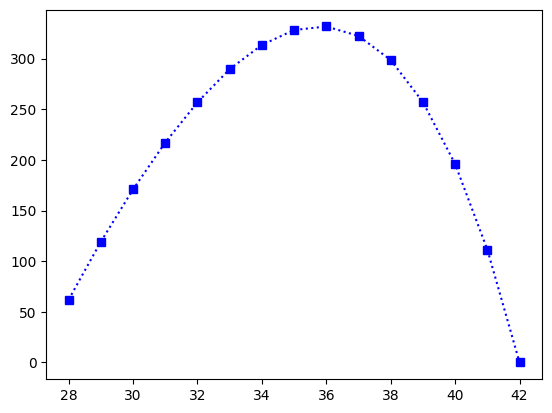

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(TablaMort['Edad'],TablaMort['Reserva'],"s:b")
plt.show() #dibujamos la grafica

Teniendo claro el ejemplo anterior, decidimos recrearlo para un grupo de asegurados. Creamos una función para facilitar los cálculos de las reservas de la siguiente manera.

In [ ]:
#En este caso se usó la tabla original pues necesitaos todos los datos
TablaMort2 = pd.read_csv("/content/drive/MyDrive/Datos ML/TablaMortalidad.csv")
TablaMort2=TablaMort2.drop(range(82,96))
TablaMort2
lx=TablaMort2['lx']
dx=TablaMort2['dx']
tasa=.05
#Seguro--------------------------------------------------------------------
def segurotemporal(x,n):
  x=x-15
  lista=[]
  for i in range(n):
    total = (1+tasa)**(-(i+1))*((dx[x+i])/lx[x])
    lista.append(total)
  return sum(lista)

#Anualidad--------------------------------------------------------------------
def segurominuscula(x,n):
  x=x-15
  lista=[]
  for i in range(n-1):
    total = (1+tasa)**(-(i+1))*(lx[x+i+1]/lx[x])
    lista.append(total)
  return sum(lista,1)

#Prima--------------------------------------------------------------------------
def prima(x,n,beneficio):
  prima = beneficio*(segurotemporal(x,n)/segurominuscula(x,n))
  return prima

#Diferencia---------------------------------------------------------------------
def diferencia(x,n,beneficio):
  diferencia=[]
  for i in range(n):
    total = prima(x,n,beneficio)-beneficio*segurotemporal(x+i,1)
    diferencia.append(total)
  return diferencia

#Reserva------------------------------------------------------------------------
def reserva(x,n,beneficio):
  x=x-15
  lista=[]
  for i in range(n):
    if i>0:
      x=x-15
      px=lx[x+i+1]/lx[x+i]
      x=x+15
      total = (diferencia(x,n,beneficio)[i]+lista[i-1])*(1+tasa)/px
      lista.append(total)
    else:
      px=lx[x+i+1]/lx[x+i]
      x=x+15
      total = (diferencia(x,n,beneficio)[i])*(1+tasa)/px
      lista.append(total)

  return lista

#Para verificar que nuestra función sirviera corroboramos con los datos del ejemplo 1.
reserva(28,15,100000)

[62.03415245028002,
 119.23868314648773,
 170.87873273124157,
 217.17410104852328,
 256.85951095175886,
 289.6010864781162,
 313.5499982298222,
 328.24908179060327,
 331.7336750812561,
 322.4142106908668,
 298.62174087035476,
 257.1023095803781,
 195.8991579247917,
 111.45626108536808,
 -2.0949557549836962e-13]

Creamos listas de manera aleatoria, para simular distintos clientes que contratan un seguro de vida temporal.

Para comezar necesitamos saber la edad de los clientes, el lapso deseado de cobertura de la poliza y la suma asegurada que desean obtener.

In [ ]:
#Calculamos la reserva para los 10 asegurados
import random


edades=[]
cobertura=[]
beneficio=[]
rv=[]
for i in range(10):
  x=random.randint(15, 65) #Edad aleatoria
  n=random.randint(1, 65-x) #Periodo de cobertura aleatorio
  b=random.randint(100000,1000000) #Beneficio aleatorio
  r=reserva(x,n,b)
  edades.append(x)
  cobertura.append(n)
  beneficio.append(b)
  rv.append(r) #Calculo de la reserva

Finalmente decidimos graficar el comportamiento de la reserva para cada asegurado de manera que la consulta sea más fácil para cada edad.

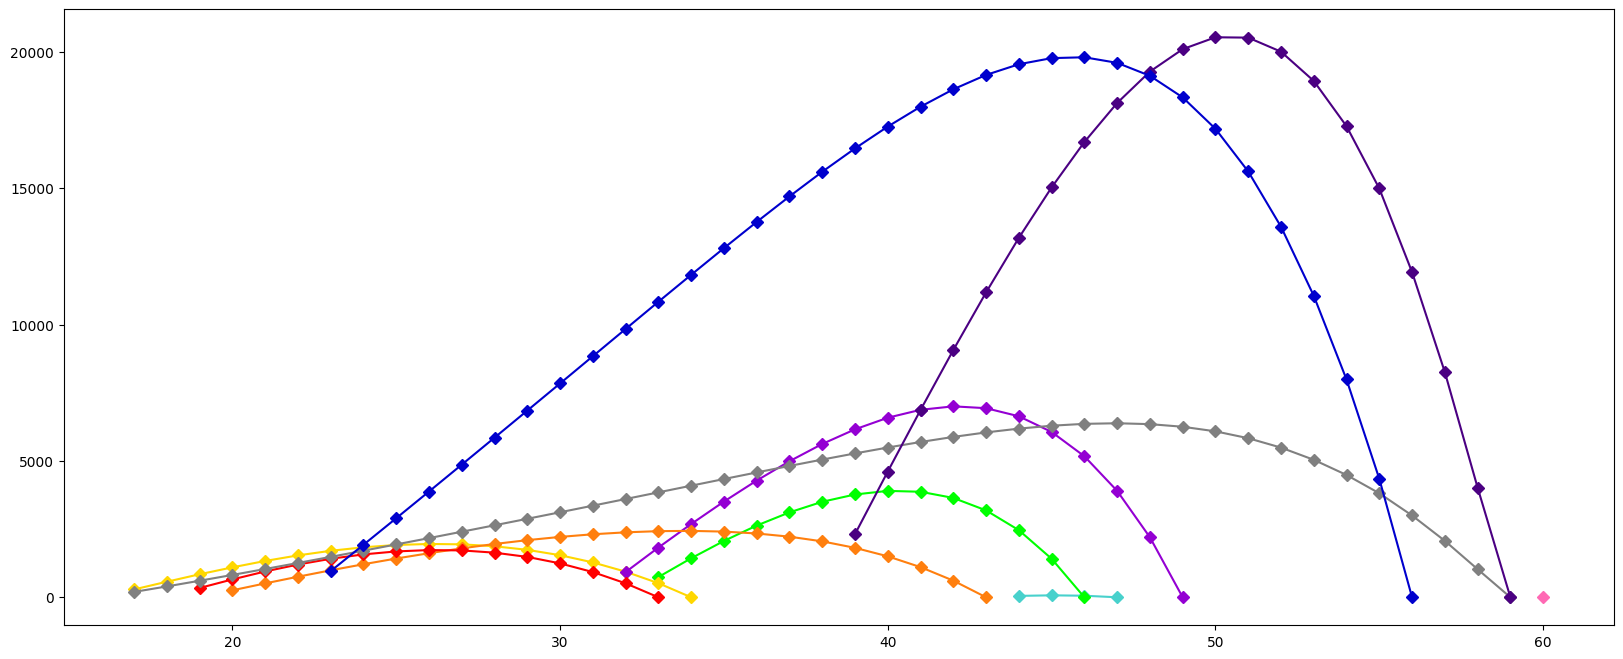

In [ ]:
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = (18,6)
ax.plot(range(edades[0], edades[0] + cobertura[0]),rv[0],"D-",color="#48D1CC") #Turquesa
ax.plot(range(edades[1], edades[1] + cobertura[1]),rv[1],"D-",color="#00FF00") #Verde
ax.plot(range(edades[2], edades[2] + cobertura[2]),rv[2],"D-",color="#FF69B4") #Rosa
ax.plot(range(edades[3], edades[3] + cobertura[3]),rv[3],"D-",color="#FFD700") #Amarillo
ax.plot(range(edades[4], edades[4] + cobertura[4]),rv[4],"D-",color="#9400D3") #Lila
ax.plot(range(edades[5], edades[5] + cobertura[5]),rv[5],"D-",color="#ff7f0e") #Naranja
ax.plot(range(edades[6], edades[6] + cobertura[6]),rv[6],"D-",color="#ff0000") #Rojo
ax.plot(range(edades[7], edades[7] + cobertura[7]),rv[7],"D-",color="#808080") #Gris
ax.plot(range(edades[8], edades[8] + cobertura[8]),rv[8],"D-",color="#4b0082") #Morado oscuro
ax.plot(range(edades[9], edades[9] + cobertura[9]),rv[9],"D-",color="#0000cd") #Azul oscuro



plt.show() #dibujamos la grafica

Además, para resolver el problema de la aseguradora, creamos un gráfico de barras apiladas y así saber la suma de las reservas en cada año.

In [ ]:
#Para hacer este tipo de gráfico necesitamos que todas las listas tengan la misma dimensión, es por eso que a las más pequeñas, en sus posiciones
#faltantes las rellenamos con ceros
for j in range (10):
  if len(rv[j])<43:
    for k in range(len(rv[j]),43):
      rv[j].append(0)

rv

[[50.89858982753611,
  71.42937555284335,
  56.95007707073467,
  1.87358712192808e-13,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [740.7869308555165,
  1429.8228359606078,
  2064.5135768932114,
  2629.4204545363286,
  3112.4234930908274,
  3500.8286942468512,
  3768.497553243049,
  3900.5284384306165,
  3868.4943737131684,
  3642.285462590476,
  3185.7500978610065,
  2460.5905127586575,
  1413.326349537429,
  1.7978940519171072e-11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [287.99499730956416,
  569.389585770203,
  8

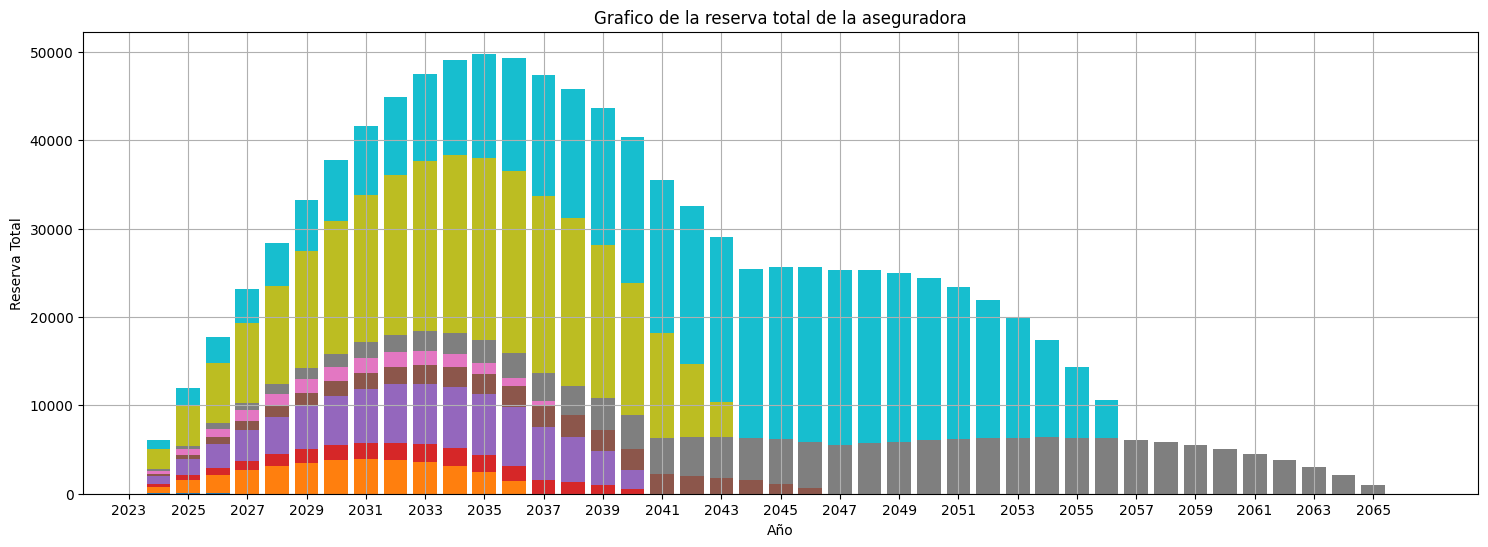

In [ ]:
#Graficamos
import numpy as np
años=[]
Hoy=2023
for i in range(43):
  años.append(Hoy+1)
  Hoy+=1

values = np.array([rv[0],rv[1],rv[2],rv[3],rv[4],
                  rv[5],rv[6],rv[7],rv[8],rv[9]])

fig, ax = plt.subplots()

# Gráfico de barras apiladas con un bucle
for i in range(values.shape[0]):
  ax.bar(años, values[i], bottom = np.sum(values[:i], axis = 0))

plt.grid()
plt.title("Grafico de la reserva total de la aseguradora")
plt.xlabel('Año')
plt.ylabel('Reserva Total')
plt.xticks(range(2023,2066,2))
plt.show()